In [4]:
t = var('t') #Global time parameter
dx_init, dy_init, dx_fin, dm = var('dx_init dy_init dx_fin dm')
time_formula2 = solve(dx_fin == -dm + (dx_init + dm)*e^(t), t)
time_formula = solve(dx_fin == -dm + (dx_init + dm)*e^((dy_init/(dx_init + dm))*t), t)[0].right().full_simplify()
#print(t, dx_init, dy_init, dx_fin, dm)
time_formula

(dm + dx_init)*log((dm + dx_fin)/(dm + dx_init))/dy_init

In [6]:
#M.G. 5/23/17, Most recent update 6/14/17, Currently functional, but sigma function is not yet implemented

t = var('t') #Global time parameter
dx_init, dy_init, dx_fin, dy_fin, dm, dc0, dc1, dt, dtf = var('dx_init dy_init dx_fin dy_fin dm dc0 dc1 dt dtf') #Dummy variables, utilized for substitution throughout code
assume(dc1 != 0) #Assumptions made for successful integration
assume(dtf > 0)
time_formula = solve(dx_fin == -dm + (dx_init + dm)*e^((dy_init/(dx_init + dm))*t), t)[0].right().full_simplify() #See 'get_time2'
x(t) = -dm + dc0*e^(dc1*t); y(t) = dc0*dc1*e^(dc1*t) #Solutions to differential equations, see (34) in paper        
Integral = (3/2)*integral((x(t)^2 + y(t)^2 + 1)/y(t), t, 0, dtf) #See 'cost' below
s = e^(dc1*dt) #s is defined as in section 4.1 in paper
star = var('star') #Intended as top right entry of g(s) as defined in section 4.1
g_temp = matrix.identity(2) + ((s-1)/(dc1^(2)*dc0*s))*matrix([[dc0 - dm, star], [1, dm - dc0*s]]) #Matrix g(s); see section 4.1 
entry01 = solve(det(g_temp) == 1, star)[0].right().full_simplify() #Value of missing entry of g(s)
gs = g_temp.substitute(star == entry01)
R = matrix([[N(cos(pi/3)), N(-sin(pi/3))], [N(sin(pi/3)), N(cos(pi/3))]]) #R as defined in section 3.5
R_inverse = R.inverse() # = matrix([[N(cos(-pi/3)), N(-sin(-pi/3))], [N(sin(-pi/3)), N(cos(-pi/3))]])
J = matrix([[0, -1], [1, 0]]) #J as defined in section 2.2


def linfrac(z): #Mobius transformation R.z, with R as defined in section 3.5
    a = N(cos(pi/3)); b = N(-sin(pi/3)); c = N(sin(pi/3)); d = N(cos(pi/3))
    return N((a*z + b)/(c*z + d))

def inverse_linfrac(z):
    a = N(cos(-pi/3)); b = N(-sin(-pi/3)); c = N(sin(-pi/3)); d = N(cos(-pi/3))
    return N((a*z + b)/(c*z + d))

def c0c1(z_init, m): 
    c0 = N(z_init.real() + m)
    c1 = N(z_init.imag()/c0)
    return (c0, c1)

def z_hat(z):
    return matrix([[z.imag(), z.real()], [0, 1]])

def X(z):
    return z_hat(z)*J*z_hat(z).inverse()

def e3(z_init, t):
    m = N(1/sqrt(3))
    (c0, c1) = c0c1(z_init, m)
    x = -m + c0*e^(c1*t)
    y = c0*c1*e^(c1*t)
    z = x + y*I
    return N(z)

def e2(z_init, t):
    m = N(-1/sqrt(3)); (c0, c1) = c0c1(N(z_init), m)
    x = -m + c0*e^(c1*t)
    y = c0*c1*e^(c1*t)
    z = x + y*I
    return N(z)

def e1(z_init, t): #Utilizing the Mobius transformation, translate points on e1 trajectory into points on e3, then map back to e1; true e1 parametrization is quite complex
    lz_init = linfrac(z_init)
    lz_t = e3(lz_init, t)
    return N(inverse_linfrac(lz_t))

def get_time2(z_init, z_fin): #if-else required to determine the sign of m
    if z_init.imag() <= z_fin.imag():
        m = 1/sqrt(3) 
    else:
        m = -1/sqrt(3)
    s = time_formula.substitute(dx_init == z_init.real(), dy_init == z_init.imag(), dx_fin == z_fin.real(), dm == m)
    return s
    
def control_trajectory(x1): #The input here should be the terminal x-point you choose after initially traveling along e3; everything is determined from here
    x0 = 0; y0 = 1
    z0 = x0 + y0*I
    y1 = N(sqrt(3)*x1 + 1)
    z1 = x1 + y1*I
    t1 = get_time2(z0, z1)
    x2 = -x1; y2 = y1 #By symmetry
    z2 = x2 + y2*I
    Rz1 = linfrac(z1)
    Rz2 = linfrac(z2)
    t2 = get_time2(Rz1, Rz2)
    x3 = x0; y3 = y0 #Notational convenience; there is no fundamental difference between (x3, y3) and (x0, y0)
    z3 = x3 + y3*I
    t3 = get_time2(z2, z3)
    solz = [z1, z2, z3]
    solt = [t1, t2, t3]
    sol = [N(solz[0]), N(solt[0]), N(solz[1]), N(solt[1]), N(solz[2]), N(solt[2])] #It takes time ti to get from z(i-1) to zi, i = 1, 2, 3
    return sol #read sol as three sets of ordered pairs: (solz[j], solt[j]), j = 0, 1, 2; we do not return it formatted as such in order to retain ease of access to elements

def path(c, t): #c = control_trajectory(x1)
    t1 = c[1]; t2 = c[3]; t3 = c[5]; z1 = c[0]; z2 = c[2]; z3 = c[4]
    if 0 <= t <= t1:
        return e3(z3, t)
    elif t1 < t < t1 + t2:
        return e1(z1, t - t1)
    elif t1 + t2 <= t <= t1 + t2 + t3:
        return e2(z2, t - (t1 + t2))
    else:
        return 0 + 1*I

def IF(m, z, t): #IF short for 'integral formula'
    return Integral.substitute(dm == m, dc0 == z.real() + m, dc1 == z.imag()/(z.real() + m), dtf == t)
            
def cost(x1): #Check to ensure the proper trajectories are used and this formula is correct!!!
    c = control_trajectory(x1)
    [z1, t1, z2, t2, z3, t3] = c
    m = N(1/sqrt(3))
    Rz1 = linfrac(z1)
    Integral1 = IF(m, z3, t1)
    Integral2 = IF(m, Rz1, t2)
    Integral3 = IF(-m, z2, t3)
    total_cost = Integral1 + Integral2 + Integral3
    return total_cost
    

a = 0.1; b = N(sqrt(3)*a + 1); c = a + b*I; d = -a + b*I
c_bar = inverse_linfrac(c); d_bar = linfrac(d)
#for i in range(0, 1000):
#    print(z1(0, 1, i/1000))

#parametric_plot((lambda t: e1(a, 3, t).real(), lambda t: e1(a, 3, t).imag()), (t, 0, .2))
#print(control_trajectory(0.1))
#parametric_plot((lambda t: e3(0.1, 3, t).real(), lambda t: e3(0.1, 3, t).imag()), (t, 0, .2))
#control_trajectory(0.1)
#for i in range(0, 1000):
#    print(N(get_time(0, 1, i, sqrt(3)*i + 1, t)[0].right()))
#def function():
#    for i in range(1, 5):
#        print(control_trajectory(i))
        
#timeit('cost(0.1)')
#get_time2(0, 1, 0.1, y(0.1))
#control_trajectory(0.1)
#cost(0.1)
def plot_path(x1, tf): #Currently performing unexpectedly for large values of tf, e.g. tf == 10; guess is that large values of tf make plot evaluate over further spaced-out points, making graph less refined, particularly over time interval of concern to us
    #assume(tf > 0) #tf is the terminal time; naturally, it is positive
    control = control_trajectory(x1)
    return parametric_plot((lambda t: path(control, t).real(), lambda t: path(control, t).imag()), (t, 0, tf))
#plot_path(0.1, 0.8)
#cost(0.1)


#time2 = control_trajectory(0.1)[3]
#z_1 = control_trajectory(0.1)[0]
#z_2 = control_trajectory(0.1)[2]
#loc = e3(inverse_linfrac(z_1), time2)
#otherloc = inverse_linfrac(z_2)
#print(loc); print(otherloc)

verbose 0 (3748: plot.py, generate_plot_points) WARNING: When plotting, failed to evaluate function at 200 points.
verbose 0 (3748: plot.py, generate_plot_points) Last error message: 'unsupported operand parent(s) for pow: '<type 'function'>' and 'Real Field with 53 bits of precision''


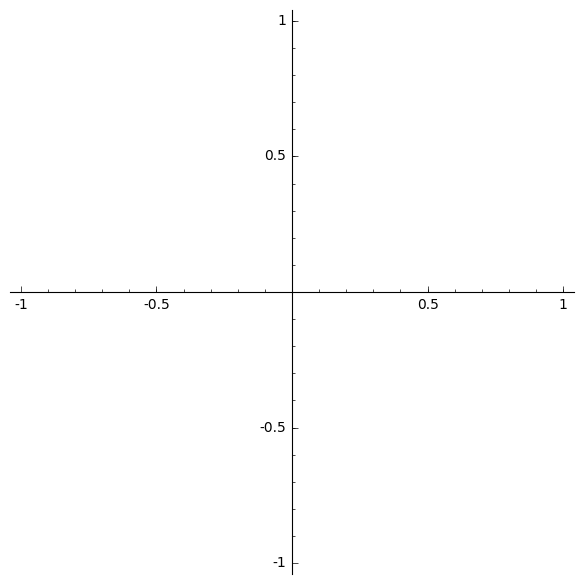

In [10]:

def gamma0(z, t): #Somehow produces error when z has no imaginary part
    m = N(1/sqrt(3))
    (c0, c1) = c0c1(z, m)
    return gs.substitute([dt == t, dc0 == c0, dc1 == c1, dm == m])

def gamma1(z, t):
    g = gamma0(z, t)
    return R*g*R_inverse

def gamma2(z, t):
    g = gamma0(z, t)
    return R_inverse*g*R

def bar(z_init, time): #Only used for obtaining z1_bar and z2_bar, not z3_bar; not implemented yet
    z1_bar = inverse_linfrac(z_init)
    w = e3(z1_bar, time)
    z2_bar = inverse_linfrac(w)
    return (z1_bar, z2_bar)

def g(control, t):
    [z1, t1, z2, t2, z3, t3] = control
    t = min(t, t1 + t2 + t3)
    t = max(t, 0)
    z1_bar = inverse_linfrac(z1) #This is correct
    w = e3(z1_bar, t2)
    z2_bar = inverse_linfrac(w) #This appears to be correct too
    if 0 <= t <= t1:
        return gamma0(z3, t)
    elif t1 < t < t1 + t2:
        return gamma0(z3, t1)*gamma1(z1_bar, t - t1)
    else:
        return gamma0(z3, t1)*gamma1(z1_bar, t2)*gamma2(z2_bar, t - (t1 + t2))
    
def e(j): #Inputs are j = 0, 1, 2, 3, 4, 5
    return vector([cos(2*pi*j/6), sin(2*pi*j/6)])

def sigma(j, control, t):
    return g(control, t)*e(j) 

def plot_g(x1, tf, i1, i2, i3, i4):
    control = control_trajectory(x1)
    return parametric_plot((lambda t: g(control, t)[i1][i2], lambda t: g(control, t)[i3][i4]), (t, 0, tf))

def plot_sigma(j, x1, tf):
    control = control_trajectory(x1)
    return parametric_plot((lambda t: sigma(j, control, t)[0], lambda t: sigma(j, control, t)[1]), (t, 0, tf))

plot_sigma(0, 0.1, 1)
#control_temp = control_trajectory(0.1)
#g(control_temp, 1)
#parametric_plot((lambda t: g(control_temp, t)[0][0], lambda t: g(control_temp, t)[0][1]), (t, 0, 3))
#plot_g(0.1, 1)
#print(X(a, b))
#print(R*X(bar.real(), bar.imag())*R_inverse)

#d1 = R*z_hat(c_bar)*J*z_hat(c_bar).inverse()*R_inverse
#f1 = z_hat(linfrac(c_bar))*J*z_hat(linfrac(c_bar)).inverse()
#print(d1); print(f1)
#d2 = R*z_hat(c_bar)
#f2 = z_hat(linfrac(c_bar))
#print(d2); print(f2)


#print(g(control_trajectory(0.1), 1)[0]); print(g(control_trajectory(0.1), 1)[1])